In [1]:
%pylab inline

import numpy as np
import scipy.sparse

from pyiga import bspline, hierarchical, assemble, geometry, solvers, vis

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define the exact solution and right-hand side for the example problem.
#
# We use sympy to symbolically compute the Laplacian for the exact solution,
# so you may need to 'pip install sympy' to be able to run this notebook.
#
EXAMPLE = 1     # choose: 1 or 2

def generate_u_rhs(example):
    import sympy
    from sympy.abc import x, y, e
    from sympy.utilities.lambdify import lambdify
    
    # specify the manufactured solution
    if example == 1:
        r2 = (x-0.5)**2 + (y-0.5)**2
        u = x * (1-x) * y * (1-y) * sympy.sin(1 / (e + r2))
    elif example == 2:
        r = sympy.sqrt((x-0.5)**2 + (y-0.5)**2)
        denom = e + sympy.tanh(12*r - 7) - sympy.tanh(-7)
        u = x * (1-x) * y * (1-y) * sympy.sin(1 / denom)
    
    # symbolically compute the gradient and the Laplacian for the right-hand side
    Lu = sympy.diff(u, x, x) + sympy.diff(u, y, y)
    dudx, dudy = sympy.diff(u, x), sympy.diff(u, y)
    return (lambdify((x, y, e), u, 'numpy'),
            lambdify((x, y, e), -Lu, 'numpy'),
            lambdify((x, y, e), dudx, 'numpy'),
            lambdify((x, y, e), dudy, 'numpy'))

sympy_u, sympy_rhs, sympy_dudx, sympy_dudy = generate_u_rhs(EXAMPLE)

dim = 2
eps = 1e-2
geo = geometry.unit_square()

def u_exact(x, y):
    return sympy_u(x, y, eps)

def u_exact_grad(x, y):
    return (sympy_dudx(x, y, eps), sympy_dudy(x, y, eps))

def rhs(x, y):
    return sympy_rhs(x, y, eps)

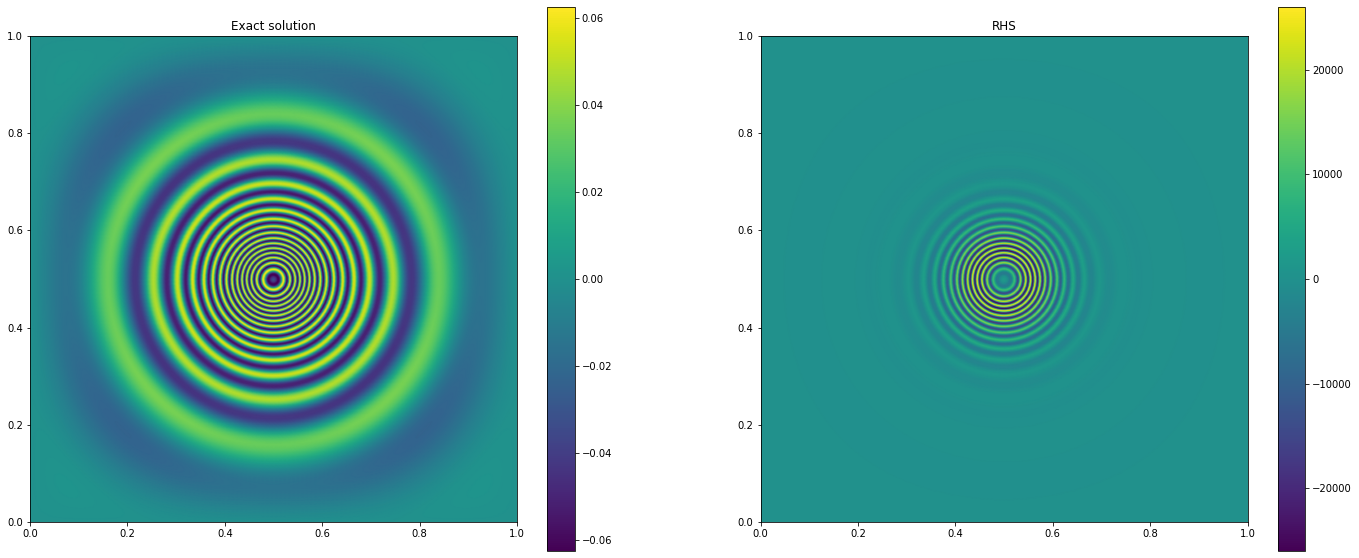

In [3]:
# plot the exact solution
figsize(24,10)
plt.subplot(1, 2, 1)
plt.title('Exact solution')
vis.plot_field(u_exact, geo=geo, res=600);
axis('scaled');
colorbar();

# plot the rhs
plt.subplot(1, 2, 2)
plt.title('RHS')
vis.plot_field(rhs, physical=True, geo=geo, res=600);
axis('scaled');
colorbar();
plt.show()

In [4]:
def doerfler_marking(errors, theta=0.9):
    """Given a list of errors, return a minimal list of indices such that the indexed
    errors have norm of at least theta * norm(errors)."""
    ix = np.argsort(errors)
    total = norm(errors)
    running = []
    marked = []
    for i in reversed(ix):
        running.append(errors[i])
        marked.append(i)
        if norm(running) >= theta * total:
            break
    return marked

In [5]:
plot_sol = True
plot_messages = False
plot_errors = True
plot_intersols = True

def test_adaptive_method(p, n0, disparity, smoother, strategy, truncate=False, tol=1e-8, maxiter=4, maxdofs=2.2e4, multi_iter=None, theta=.8):
    # set up a one-level hierarchical spline space
    hs = hierarchical.HSpace(dim * (bspline.make_knots(p, 0.0, 1.0, n0),),
                             truncate=truncate, disparity=disparity,
                             bdspecs=['left', 'right', 'top', 'bottom'])
    
    # Create a second piecewise constant HSpace with the same mesh for the error
    # estimator. Each active function in this space is the characteristic function
    # for an active cell in hs.
    hs_p0 = hierarchical.HSpace(dim * (bspline.make_knots(0, 0.0, 1.0, n0),), disparity=np.inf)

    # keep track of errors for plotting
    numdofs, estimatederrors, exacterrors, energyerrors = [], [], [], []

    # assembler parameters
    params = {'geo': geo, 'f': rhs, 'u_exact': u_exact, 'u_exact_grad': u_exact_grad}
    
    # initialize solution vector
    u = None
    
    # compute L2 norm of the rhs
    L2norm_f = sqrt(assemble.assemble('f**2 * v * dx',
                            2 * (bspline.make_knots(4, 0.0, 1.0, 200),), params).sum())
    
    # compute L2 norm of the exact solution
    L2norm_u_exact = sqrt(assemble.assemble('u_exact**2 * v * dx',
                            2 * (bspline.make_knots(4, 0.0, 1.0, 200),), params).sum())
    
    # compute energy norm of the exact solution
    energynorm_u_exact = sqrt(assemble.assemble('inner(u_exact_grad, u_exact_grad) * v * dx',
                            2 * (bspline.make_knots(4, 0.0, 1.0, 200),), params).sum())

    for adapt_iter in range(maxiter):
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        # assemble the problem
        A_hb = assemble.assemble('inner(grad(u), grad(v)) * dx', hs, params)
        f_hb = assemble.assemble('f * v * dx', hs, params)

        # solve using local multigrid
        u = solvers.iterate_hmultigrid(hs, A_hb, f_hb, strategy, smoother, x0=u, iter=multi_iter)
        if plot_messages:
            print('solved for', hs.numdofs, 'dofs in', multi_iter, 'iteration(s)')
        
        # current solution as a hierarchical spline function
        u_sol = hierarchical.HSplineFunc(hs, u)
        
        # ---------------------------------------------------------------------
        # ESTIMATE
        # ---------------------------------------------------------------------
        # compute the residual error estimator and the error to the exact solution per active cell
        params['u_sol'] = u_sol
        err_estimator = assemble.assemble('(f + div(grad(u_sol)))**2 * v * dx', hs_p0, params)
        err_exact     = assemble.assemble('(u_sol - u_exact)**2 * v * dx', hs_p0, params)
        err_energy    = assemble.assemble('inner(grad(u_sol) - u_exact_grad, grad(u_sol) - u_exact_grad) * v * dx', hs_p0, params)

        actcells = hs.active_cells(flat=True)   # list of (lv, cellidx) pairs
        h = array([2**(-lv) for (lv, _) in actcells])    # mesh size factor for each active cell
        err_estimator *= h**2     # scaling factor h^2 for error estimator

        if plot_errors:
            plt.figure(figsize=(24,6))
            plt.subplot(1, 3, 1)
            ax, p = vis.plot_active_cells(hs, err_estimator, cmap='cividis')
            plt.colorbar(p, ax=ax);
            plt.axis('scaled')
            plt.title('Error estimator')
            plt.subplot(1, 3, 2)
            ax, p = vis.plot_active_cells(hs, err_exact, cmap='cividis')
            plt.colorbar(p, ax=ax);
            plt.axis('scaled')
            plt.title('$L^2$ error')
            plt.subplot(1, 3, 3)
            ax, p = vis.plot_active_cells(hs, err_energy, cmap='cividis')
            plt.colorbar(p, ax=ax);
            plt.axis('scaled')
            plt.title('Energy error')
            plt.show()

        est = sqrt(err_estimator.sum())
        relest = est / L2norm_f
        L2err = sqrt(err_exact.sum())
        relL2err = L2err / L2norm_u_exact
        energyerr = sqrt(err_energy.sum())
        relenergyerr = energyerr / energynorm_u_exact
        
        if plot_messages:
            print("Relative estimator: {:.3e}".format(relest))
            print("Relative L2 error: {:.3e}".format(relL2err))
            print("Relative energy error: {:.3e}".format(relenergyerr))
        
        numdofs.append(hs.numdofs)
        exacterrors.append(relL2err)
        estimatederrors.append(relest)
        energyerrors.append(relenergyerr)
        
        # ---------------------------------------------------------------------
        # MARK
        # ---------------------------------------------------------------------
        
        marked_cells = doerfler_marking(err_estimator, theta=theta)
        
        # ---------------------------------------------------------------------
        # REFINE
        # ---------------------------------------------------------------------
        
        # convert marked cells to level-cell dict
        marked = {lv: set() for lv in range(hs.numlevels)}
        for k in marked_cells:
            marked[actcells[k][0]].add(actcells[k][1])

        num_marked = tuple(len(marked[lv]) for lv in range(hs.numlevels))
        num_cells = hs.total_active_cells
        
        if plot_intersols:
            plt.figure(figsize=(14,6))
            plt.subplot(1, 2, 1)
            vis.plot_field(u_sol, geo=geo, res=400)
            plt.colorbar()
            plt.axis('scaled')
            plt.title('Intermediate solution after iteration ' + str(adapt_iter))
            plt.subplot(1, 2, 2)
            vis.plot_hierarchical_cells(hs, marked)
            plt.axis('scaled')
            plt.title('Marked cells')
            plt.show()

        # do the refinement
        hs_old = hs.copy()
        refined = hs.refine(marked)
        hs_p0.refine(refined)    # keep P0 space in sync with the trial space
        u = hs_old.prolongate_to(hs) @ u # prolongate u
        
        # print statistics on marked/refined cells
        num_refined = tuple(len(refined[lv]) for lv in range(max(marked.keys()) + 1))
        if plot_messages:
            print('Marked cells per level: {} ({:.1f}% of cells marked, {:.1f}% of cells refined)'.format(
                num_marked,
                100 * sum(num_marked) / num_cells,
                100 * sum(num_refined) / num_cells))

    # iteration has terminated - plot errors and return the solution
    if plot_sol:
        plt.figure(figsize=(18,6))
        plt.subplot(1, 3, 1)
        plt.loglog(numdofs[2:], estimatederrors[2:], 'o-')
        plt.xlabel('dofs')
        plt.ylabel('relative estimator')
        plt.subplot(1, 3, 2)
        plt.loglog(numdofs[2:], exacterrors[2:], 'o-')
        plt.xlabel('dofs')
        plt.ylabel('relative $L_2$ error')
        plt.subplot(1, 3, 3)
        plt.loglog(numdofs[2:], energyerrors[2:], 'o-')
        plt.xlabel('dofs')
        plt.ylabel('relative energy error')
        plt.show()
    return u_sol

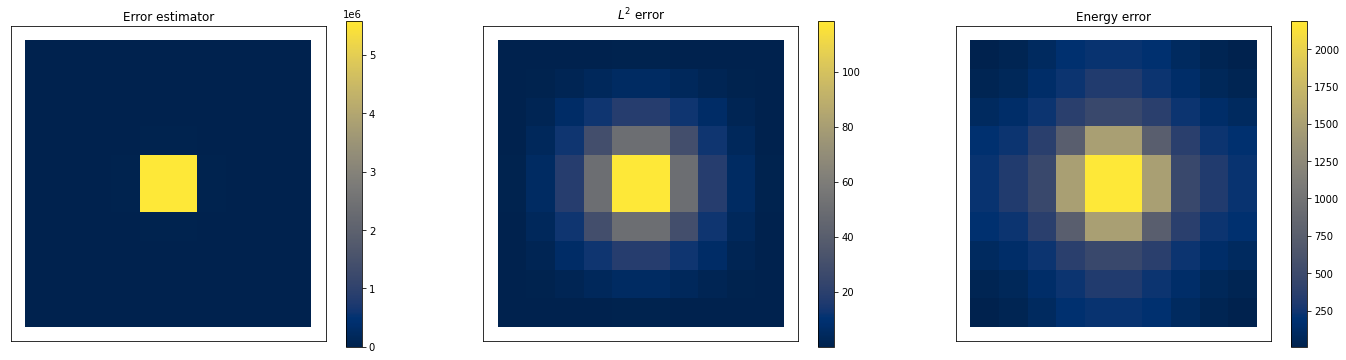

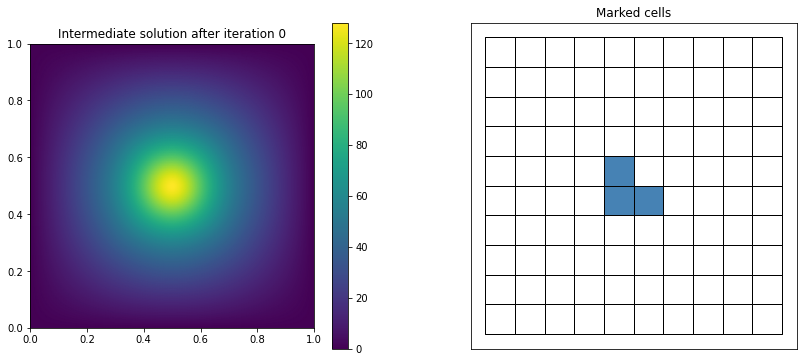

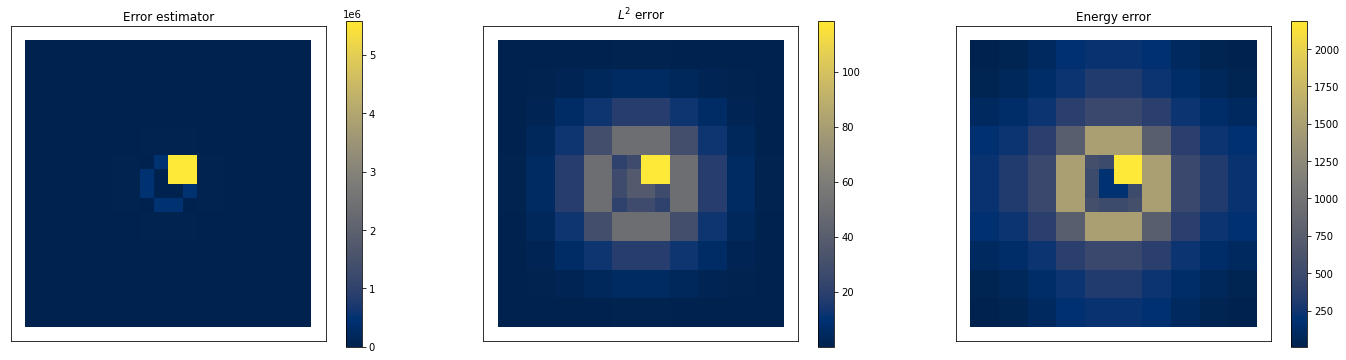

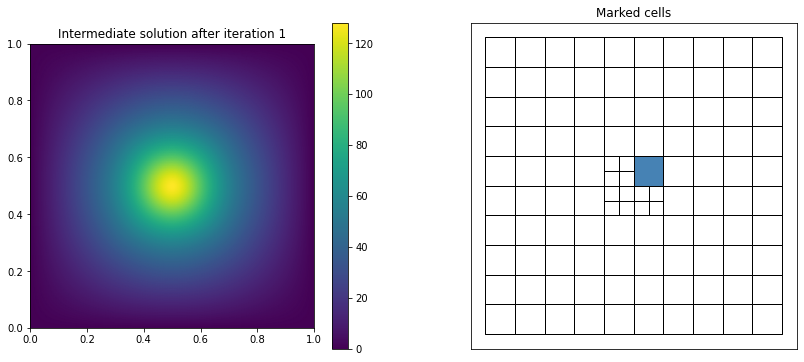

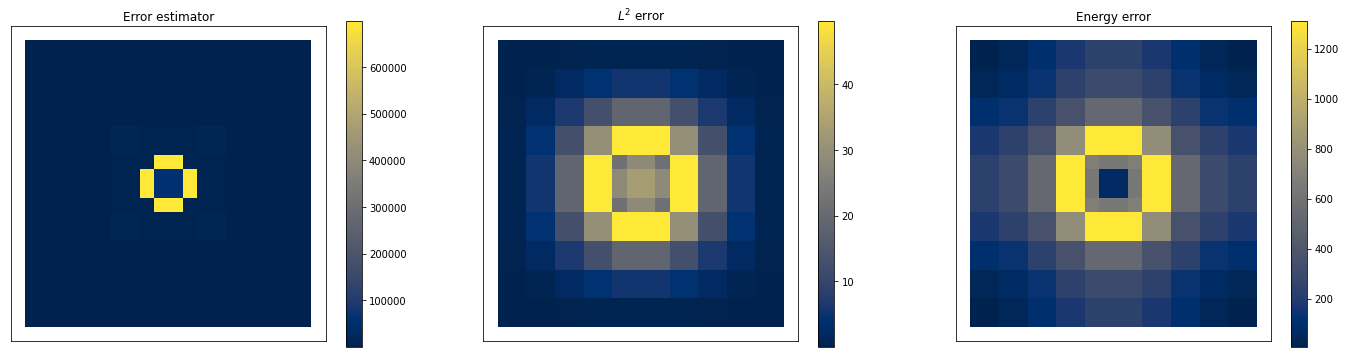

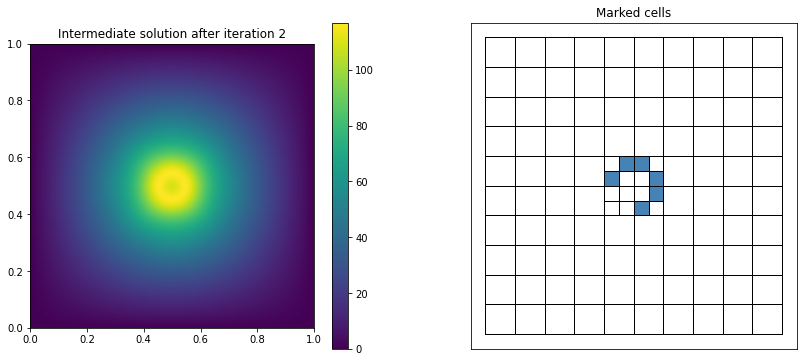

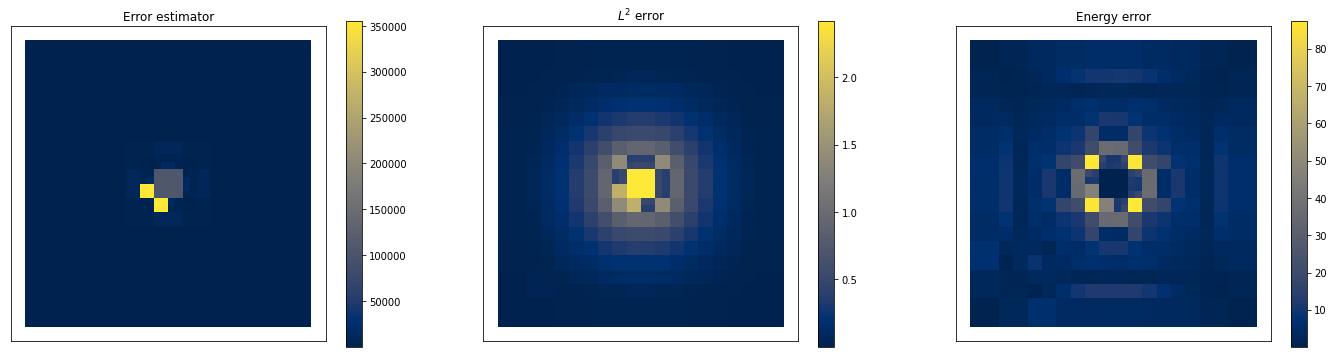

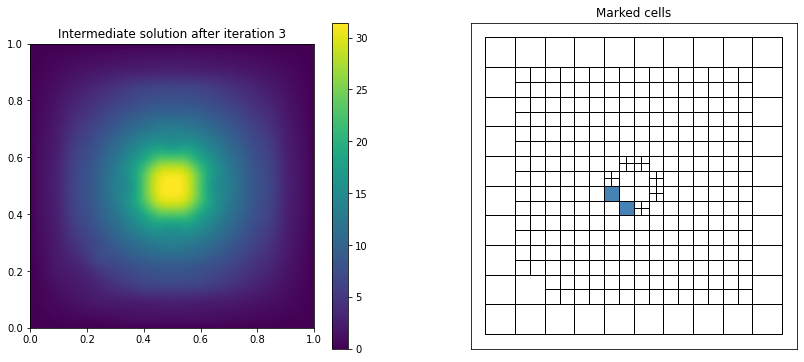

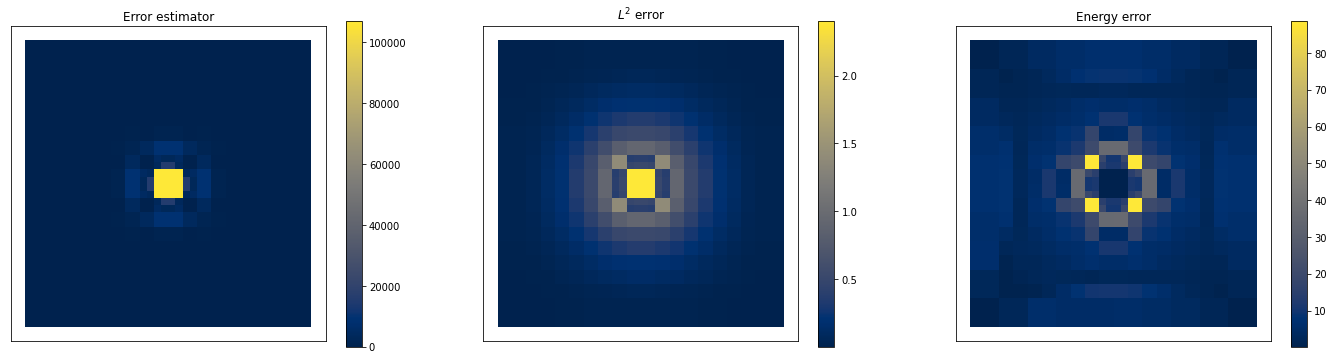

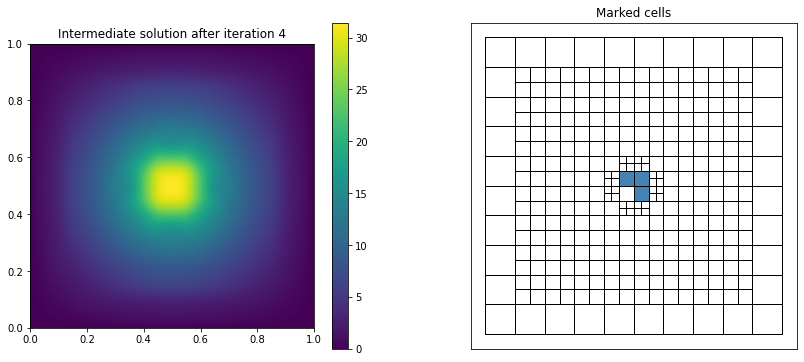

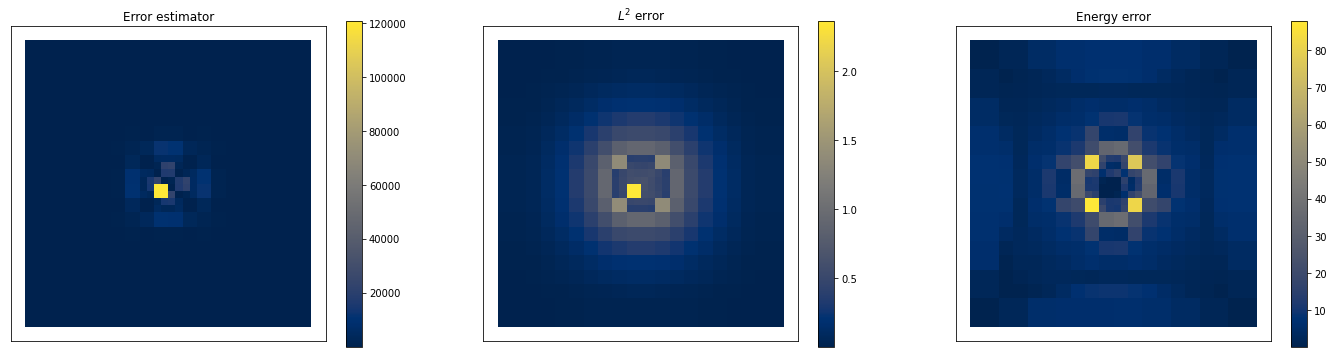

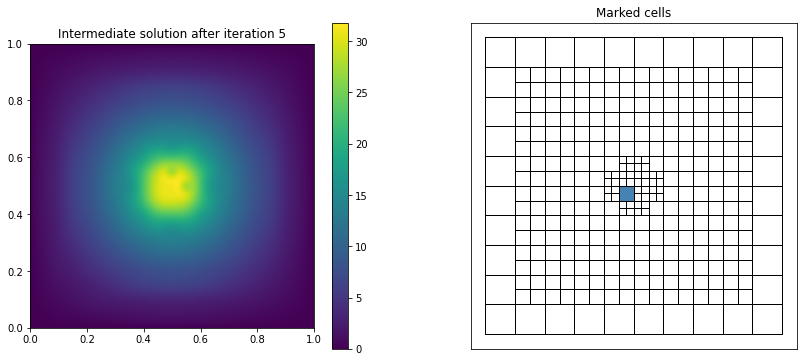

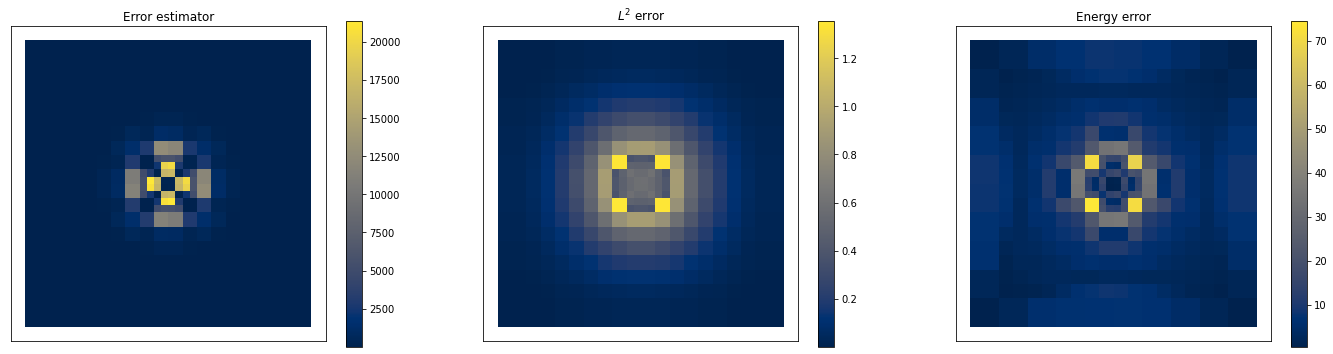

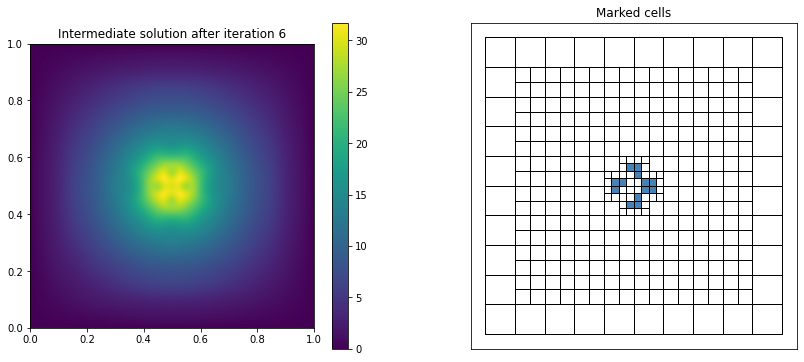

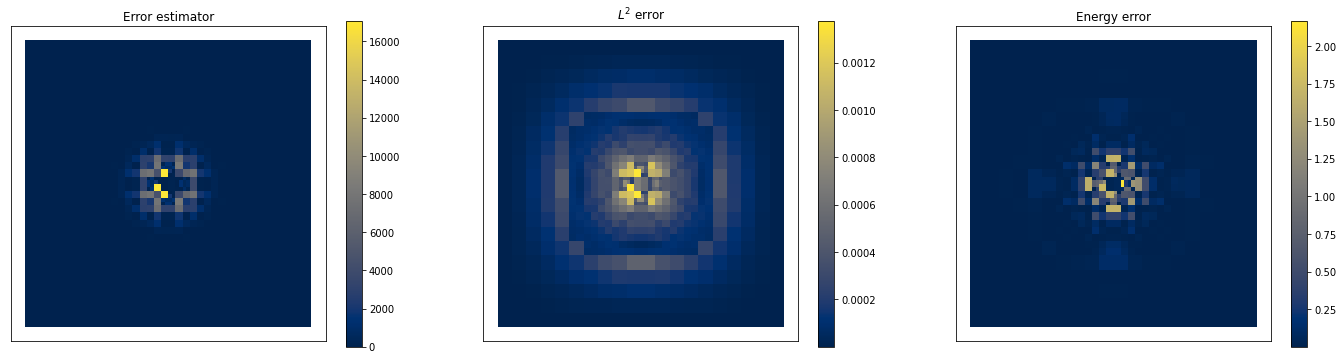

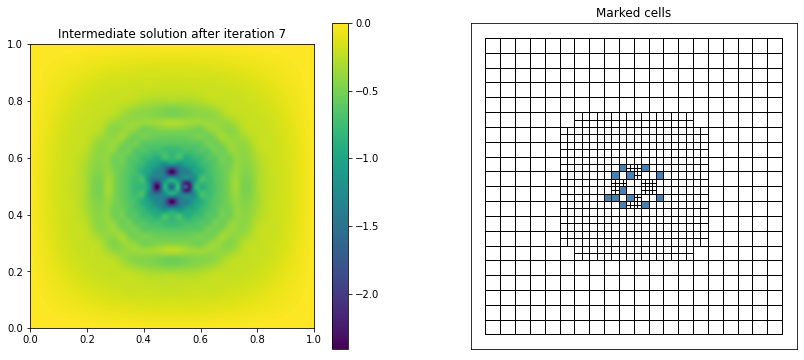

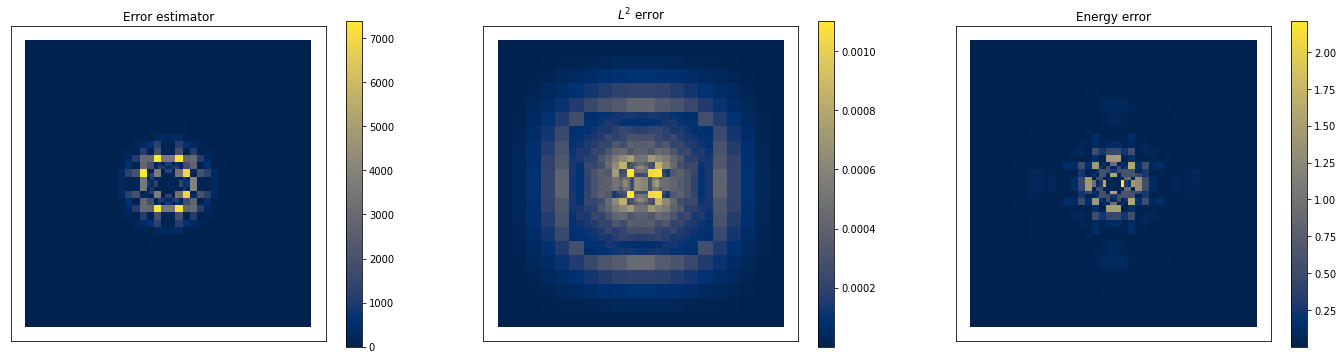

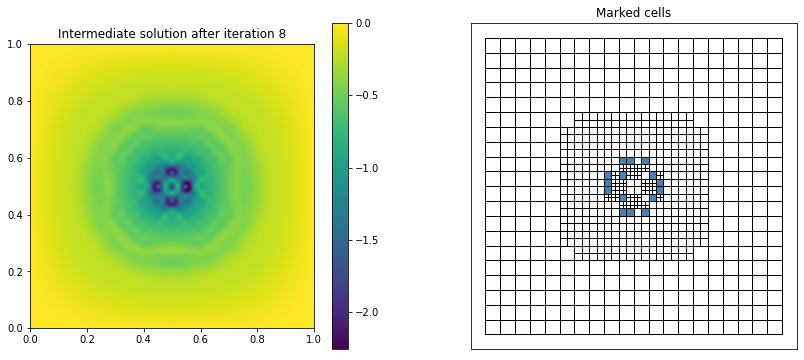

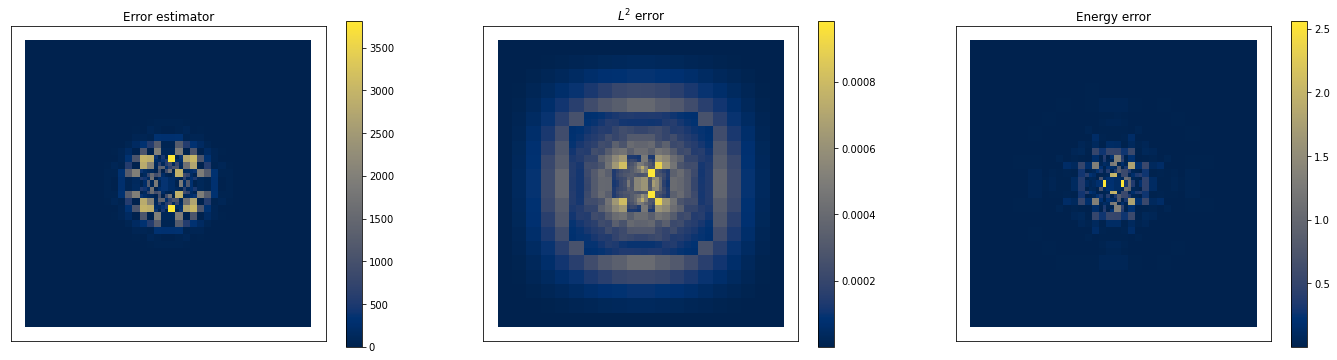

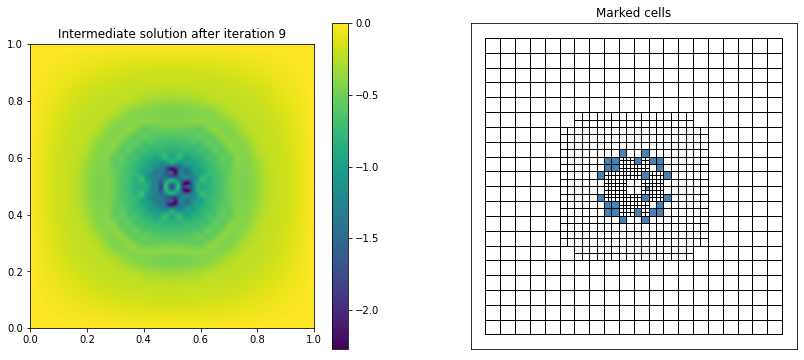

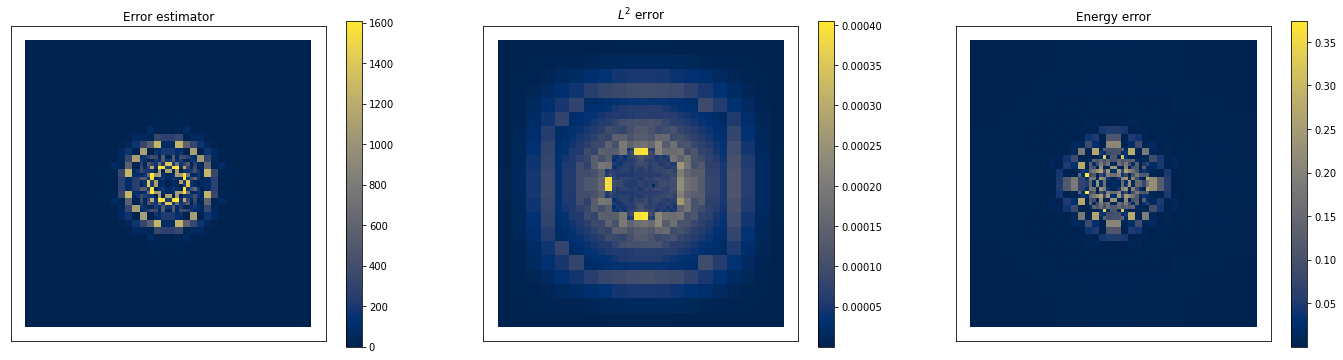

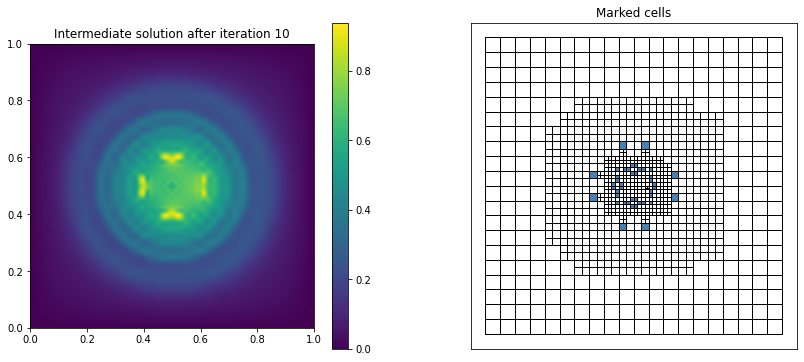

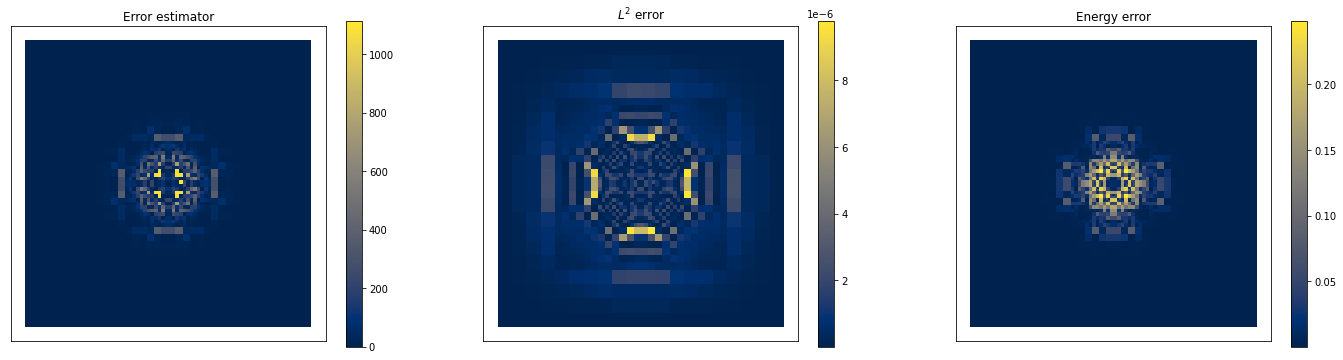

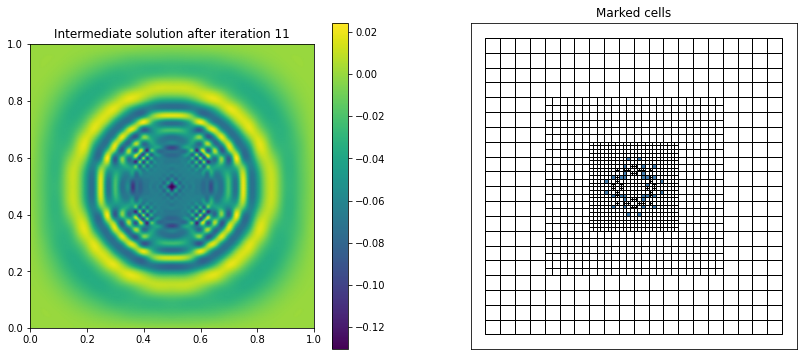

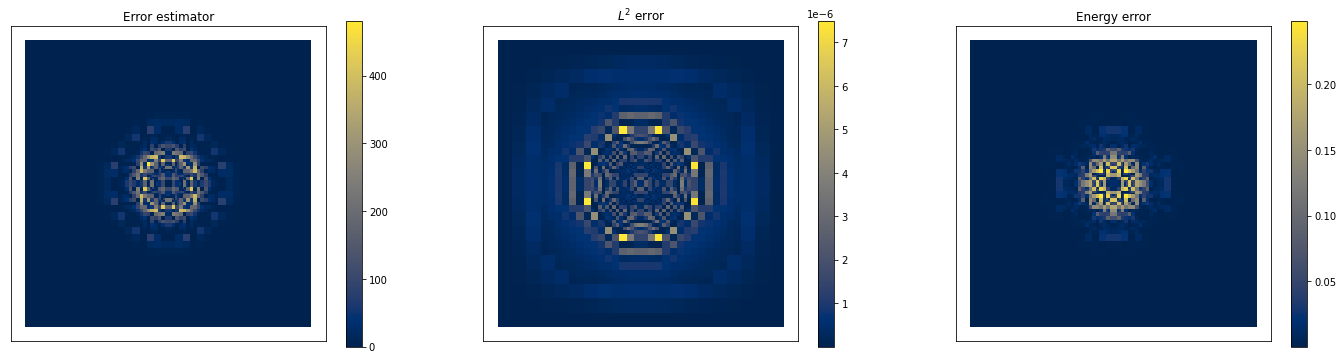

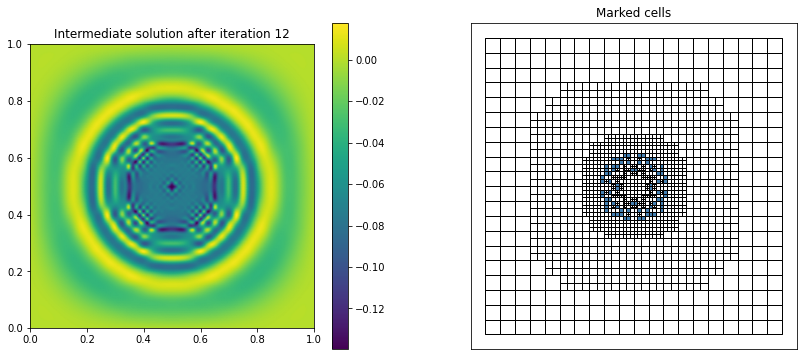

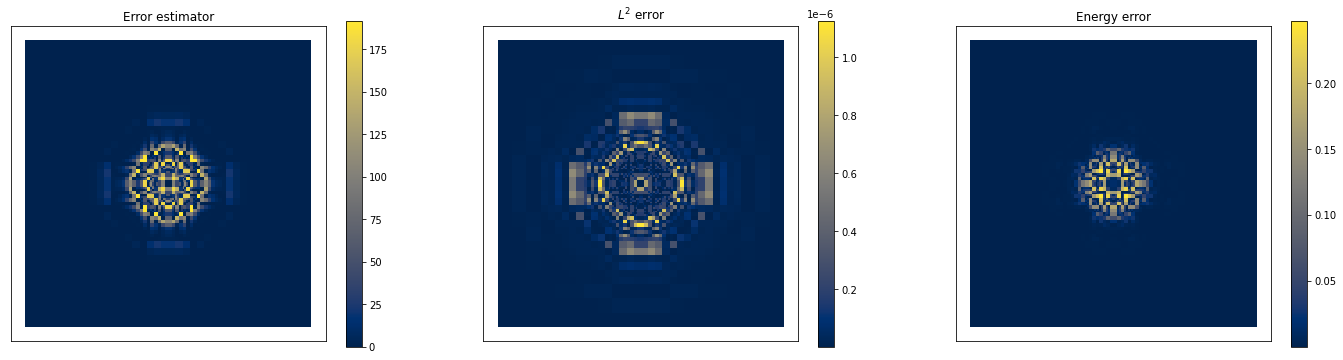

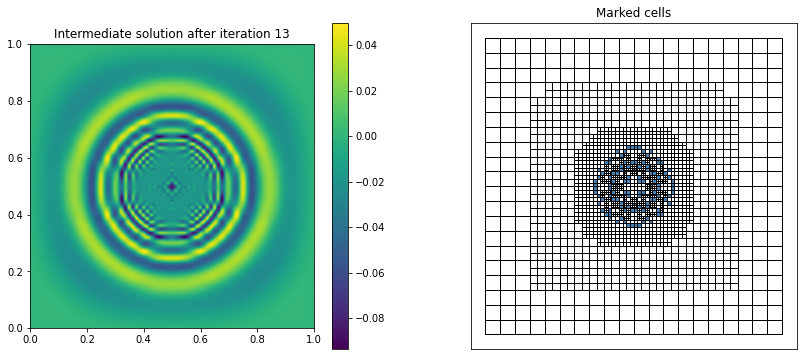

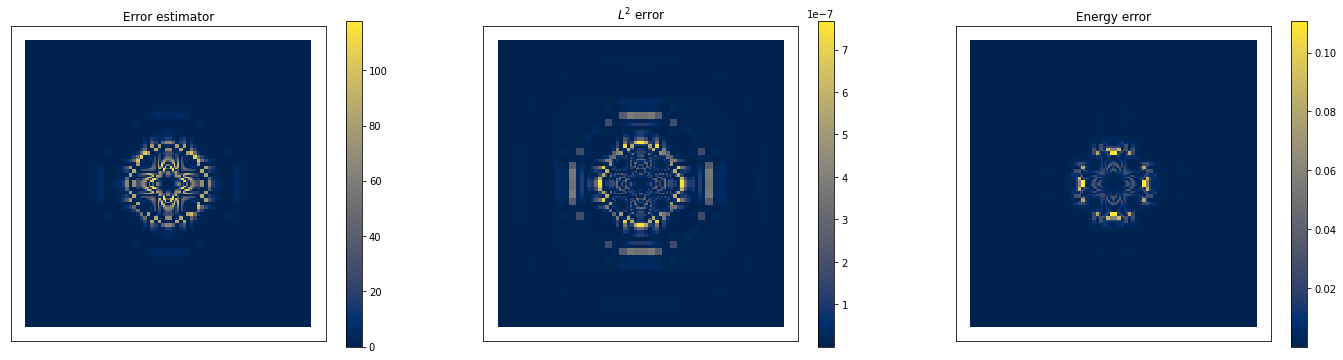

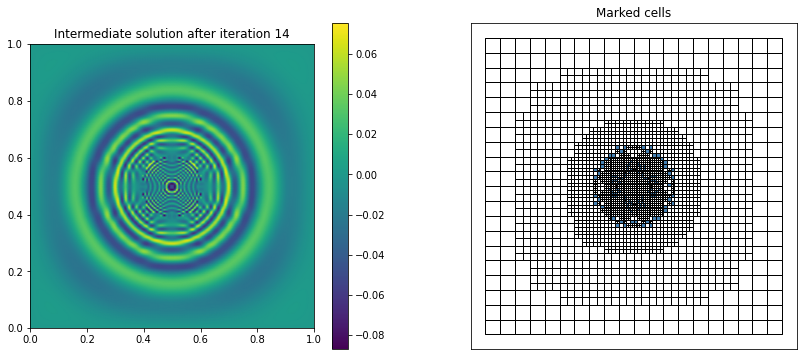

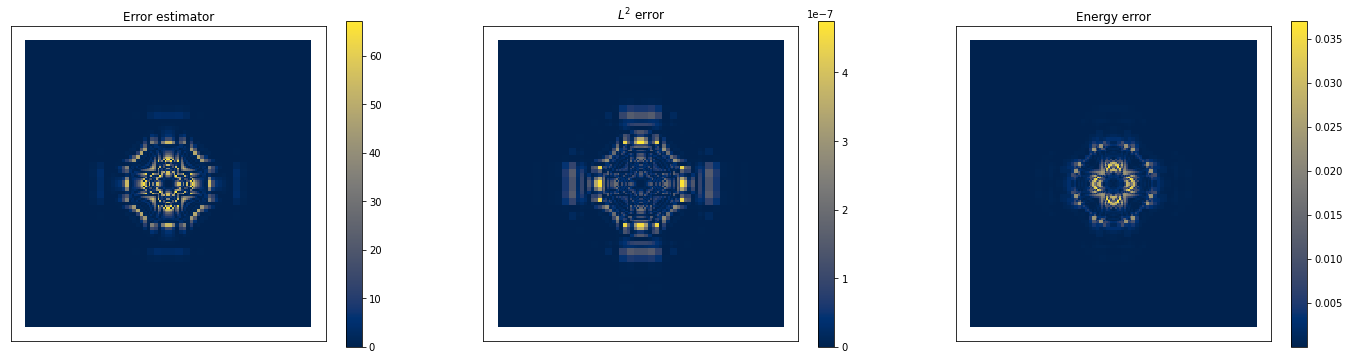

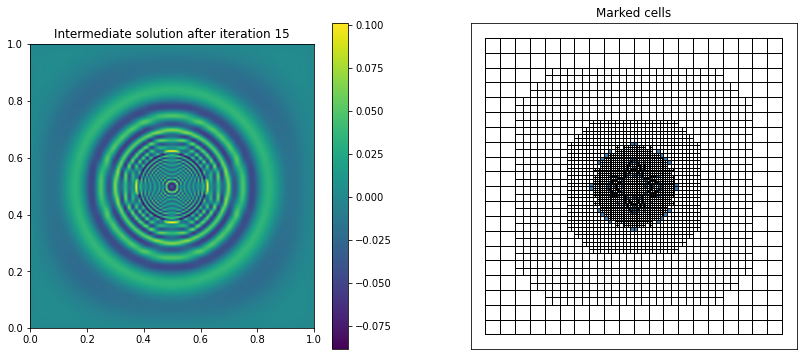

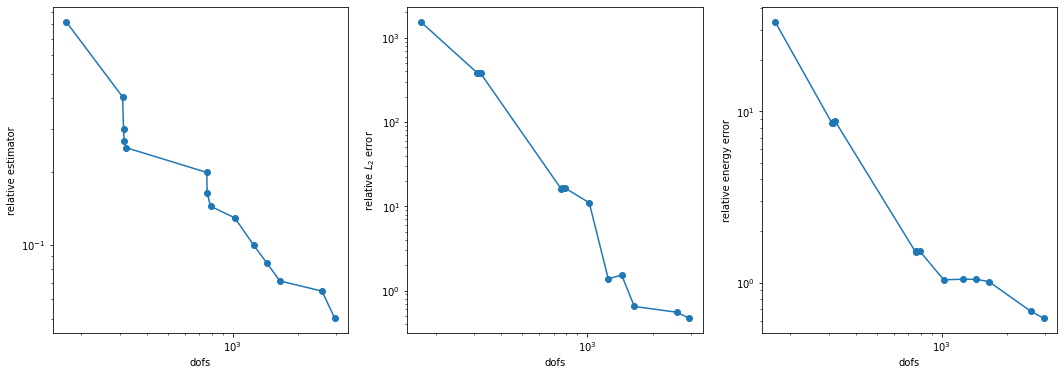

CPU times: user 1min 3s, sys: 6.81 s, total: 1min 10s
Wall time: 52.4 s


In [6]:
%time u_sol = test_adaptive_method(3, 10, 1, 'symmetric_gs', 'new', truncate=False, maxiter=16, multi_iter=1)

In [7]:
# plot the computed solution
figsize(12, 10)
vis.plot_field(u_sol, geo=geo, res=600);
plt.title('Local multigrid solution')
axis('scaled');
colorbar();
plt.show()

AssertionError: Wrong length of input vector